
# Progetto IronITA
*Progetto realizzato da Simona Sette (544298)*

Dopo aver scelto un Neural Language Model tra quelli visti a lezione, condurre un processo di fine-tuning per 5 epoche. Riportare i seguenti risultati:

*   riportare le curve di loss di training e di validation;
*   per ogni epoca valutare il sistema sul validation set;
*   alla fine dell’ultima epoca, riportare la valutazione del sistema sul test set ufficiale.



**Questo codice è stato eseguito su Google Colab: per questo motivo alcune celle di markdown non mostrano un corretto display in Jupyter Lab.**

**Per una corretta visualizzazione aprire il file in Google Colab.**

### **Librerie**

Segue una cella contenente le stringhe da eseguire come codice al fine di effettuare il download delle librerie necessarie all'esecuzione del codice. 

**Utilizzare la versione di trasformers specificata**, in quanto versioni successive danno problemi su una dipendenza legata ad "accelerate" (modulo "PartialState").
 - Data in cui è stato riscontrato problema di dipendenze: 11/05/2023

In [1]:
!pip install datasets
!pip install evaluate
!pip install scikit-learn
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.9 MB/s eta 0:0

### **Imports**

In [2]:
import os
from google.colab import drive

import numpy as np
import pandas as pd
import datasets
import evaluate
import seaborn as sns

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import warnings
# Ignora tutti i warning
warnings.filterwarnings("ignore")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **Caricamento dei dati**

Importo il mio *Google Drive* per poter accedere alla cartella contenente i dati del task.

In [3]:
# Importo il mio *Google Drive* per poter accedere alla cartella contenente i dati del task.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df= pd.read_csv('/content/drive/My Drive/bert_codes_LC2/dataset_ironita_2018.csv', delimiter=",")  
#  Crea un nuovo DataFrame per i dati di training
train_data = df[df["set"] == "training"]
# Crea un nuovo DataFrame per i dati di test
test_data = df[df["set"] == "test"]

In [5]:
# Seleziono unicamente le feature d'interesse (testi e label)
train_data=train_data[["text","irony"]].reset_index(drop=True)
test_data=test_data[["text","irony"]].reset_index(drop=True)

## **Preprocessing dei dati**

In [6]:
# I dati vengono prima convertiti nel formato datasets
train = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))

# Splitting in train e dev del training set
train_dev = train.train_test_split(test_size=0.1)

train = train_dev["train"]
dev = train_dev["test"]

# Stampo 'train' per visualizzarne la struttura
print(train, "\n")
print("Esempio di testo estratto dal train:", train['text'][0], "\n")
print("Esempio di label estratto dal train:", train['irony'][0], "\n")

# Shape dei dati di train, dev e test
print("Dimensione dei set di training, development e test:  \n ","(numero di istanze, numero di features)")
print("Train:", train.shape)
print("Dev:", dev.shape)
print("Test:", test.shape)

Dataset({
    features: ['text', 'irony'],
    num_rows: 3579
}) 

Esempio di testo estratto dal train: @matteosalvinimi se poi si scopre che a donare il sangue sono tutti immigrati ti prende un infarto 

Esempio di label estratto dal train: 1 

Dimensione dei set di training, development e test:  
  (numero di istanze, numero di features)
Train: (3579, 2)
Dev: (398, 2)
Test: (872, 2)


## **Caricamento dei modelli** ##
E' stato deciso di provare due diversi modelli:
- un modello specificatamente addestrato su tweet in lingua italiana disponibile su Hugging Face. Per ulteriori informazioni: https://huggingface.co/osiria/bert-tweet-base-italian-uncased
- un modello standard per la lingua italiana di grandi dimensioni. Per ulteriori informazioni:https://huggingface.co/dbmdz/bert-base-italian-xxl-uncased

La ragione dietro questa scelta è stata poter disporre di un mezzo di paragone tra un modello addestrato specificatamente su dati di tweet ma di dimensioni contenute ed un modello più classico generale per la lingua italiana di grandi dimensioni. 

E' stato deciso di utilizzare gli stessi argomenti e metriche  per entrambi al fine di poterne valutare le differenze in termini di prestazioni.

In [7]:
# Creo una variabile 'model' dove specificherò il modello da utilizzare
model_name_tweet = "osiria/bert-tweet-base-italian-uncased"
model_name_basic= "dbmdz/bert-base-italian-xxl-uncased"

# Carico il modello
model_tweet = AutoModelForSequenceClassification.from_pretrained(model_name_tweet, num_labels=2)
model_basic = AutoModelForSequenceClassification.from_pretrained(model_name_basic, num_labels=2)

# Carico il tokenizzatore
tokenizer_tweet = AutoTokenizer.from_pretrained(model_name_tweet)
tokenizer_basic = AutoTokenizer.from_pretrained(model_name_basic)

Some weights of the model checkpoint at osiria/bert-tweet-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at osiria

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification

## **Tokenizzazione dei tweet** ##

Tokenizziamo i testi dei tweet in modo da renderli idonei alle elaborazioni di BERT.

In [8]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
def tokenize_tweet(batch):
    # Applica tokenizzazione ai testi dei tweet: 512 subwords massime, se sequenza è più lunga viene troncata, se invece non arriva a 512 viene riempito di zeri
    tokens = tokenizer_tweet(batch['text'], padding=True, truncation=True, max_length=512)
    # Assegna le label per ogni tweet
    tokens['label'] = batch["irony"]
    return tokens

# Funzione che applica la tokenizzazione ai dati di training, dev e test
def tokenize_basic(batch):

     # Applica tokenizzazione ai testi dei tweet: 512 subwords massime, se sequenza è più lunga viene troncata, se invece non arriva a 512 viene riempito di zeri
    tokens = tokenizer_basic(batch['text'], padding=True, truncation=True, max_length=512)
     # Assegna le label per ogni tweet
    tokens['label'] = batch["irony"]
    return tokens

# Tokenizzazione dei set per il modello specializzato sui tweet
train_tweet = train.map(tokenize_tweet, batched=True)
dev_tweet = dev.map(tokenize_tweet, batched=True)
test_tweet = test.map(tokenize_tweet, batched=True)

# Tokenizzazione dei set per il modello non specializzato sui tweet
train_basic = train.map(tokenize_basic, batched=True)
dev_basic = dev.map(tokenize_basic, batched=True)
test_basic = test.map(tokenize_basic, batched=True)

# Format dei set per il modello specializzato sui tweet
train_tweet.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev_tweet.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tweet.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Format dei set per il modello non specializzato sui tweet
train_basic.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev_basic.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_basic.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3579 [00:00<?, ? examples/s]

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/3579 [00:00<?, ? examples/s]

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

## **Addestramento del modello**

Step di definizione di:
- *Training Arguments*: gli argomenti di addestramento (e.g. numero di epoche/step, learning rate, batch_size, logging/saving strategy, etc.);
- *Metrica*: metrica di addestramento, per valutare le performance del modello in fase di evaluation;
- *Trainer*: oggetto della libreria *Transformers* che processa tutti gli argomenti e, tramite il metodo *.train()* fa partire l'addestramento. I trainer sono due, uno per ogni modello.

### **Training Arguments**

In [ ]:
# Argomenti per il Trainer
num_epochs = 5

# Definisco argomenti per entrambi gli addestramenti

training_args_tweet = TrainingArguments(
    f"{model_name_tweet}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    num_train_epochs=num_epochs,
    # Registra un log ogni 10 passi di addestramento
    logging_steps=10,
    learning_rate= 5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    load_best_model_at_end=True
)

training_args_basic = TrainingArguments(
    f"{model_name_basic}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    num_train_epochs=num_epochs,
    # Registra un log ogni 10 passi di addestramento
    logging_steps=10,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    load_best_model_at_end=True
)

### **Metrica**

In [ ]:
# La funzione prende in input le predictions del modello 
def compute_metrics(eval_pred):

  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  # Applica argmax alle predictions
  predictions = np.argmax(predictions, axis=1)
  
   # Calcola e restituisce l'F-Score fra le predictions e le true labels
  return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

### **Trainer per modello specializzato sui tweet**

In [ ]:
#Definizione del trainer 
trainer_tweet = Trainer(
    model_tweet,
    training_args_tweet,
    train_dataset=train_tweet,
    eval_dataset=dev_tweet,
    tokenizer=tokenizer_tweet,
    compute_metrics=compute_metrics,
)

# Training
trainer_tweet.train()
# Specifichiamo dover voler salvare il modello
trainer_tweet.save_model("/content/drive/My Drive/bert_codes_LC2/FINETUNED_MODEL/tweet_model")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.621100,0.547654,0.722617
2,0.519900,0.480125,0.783657
3,0.396700,0.535069,0.770533
4,0.246900,0.681969,0.793928
5,0.151900,0.829491,0.786274


###**Trainer per modello non specializzato sui tweet**

In [ ]:
#Definizione del trainer 
trainer_basic = Trainer(
    model_basic,
    training_args_basic,
    train_dataset=train_basic,
    eval_dataset=dev_basic,
    tokenizer=tokenizer_basic,
    compute_metrics=compute_metrics,
)

# Training
trainer_basic.train()
# Specifichiamo dover voler salvare il modello
trainer_basic.save_model("/content/drive/My Drive/bert_codes_LC2/FINETUNED_MODEL/basic_model")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.546800,0.427629,0.795246
2,0.339700,0.422377,0.808876
3,0.159300,0.832961,0.791356
4,0.055400,1.043448,0.783789
5,0.026100,1.116152,0.796332


## **Evaluation dei modelli**

### **Monitoraggio della loss sul dataset di training e di evaluation**


####**Modello specializzato sui tweet**

<Axes: xlabel='Epoch', ylabel='Loss'>

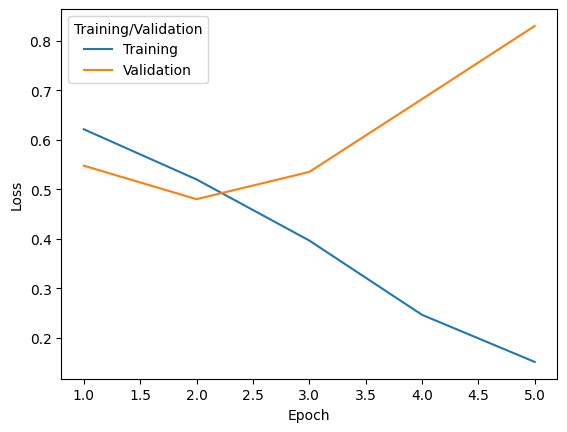

In [ ]:
# Ottiene la cronologia dei log dall'oggetto del trainer
log_history_tweet = trainer_tweet.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df_tweet = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

# Itero sulla cronologia dei log
for log_data in log_history_tweet:
  epoch = int(log_data["epoch"])

  # Se è presente una chiave "loss" nel log
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    # Memorizzo la loss di training nel dataframe
    df_tweet = df_tweet.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)
  # Se è presente una chiave "eval_loss" nel log

  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    # Memorizzo la loss di validation nel dataframe
    df_tweet = df_tweet.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Validation"}, ignore_index=True)


# Lineplot della loss
sns.lineplot(data=df_tweet, x="Epoch", y="Loss", hue="Training/Validation")

####**Modello non specializzato sui tweet**

<Axes: xlabel='Epoch', ylabel='Loss'>

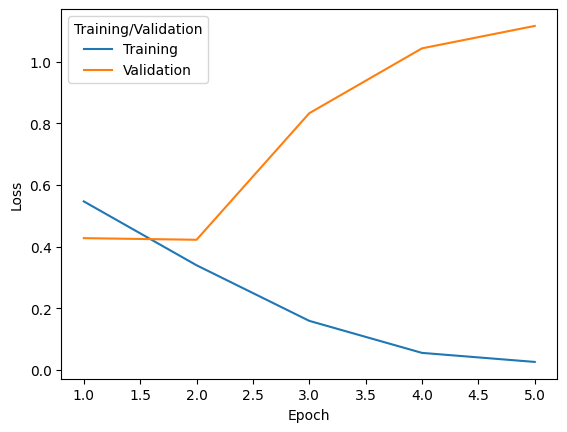

In [ ]:
# Ottiene la cronologia dei log dall'oggetto del trainer
log_history_basic = trainer_basic.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df_basic = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

# Itero sulla cronologia dei log
for log_data in log_history_basic:
  epoch = int(log_data["epoch"])

  # Se è presente una chiave "loss" nel log
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    # Memorizzo la loss di training nel dataframe
    df_basic = df_basic.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)

  # Se è presente una chiave "eval_loss" nel log
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    # Memorizzo la loss di validation nel dataframe
    df_basic = df_basic.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Validation"}, ignore_index=True)


# Lineplot della loss
sns.lineplot(data=df_basic, x="Epoch", y="Loss", hue="Training/Validation")

### **Calcolo performance sul dataset di test**


In [ ]:
# Otteniamo come output le prediction del modello e le metriche (e.g. weighted F1) di valutazione per entrambi i modelli
output_predictions_tweet = trainer_tweet.predict(test_tweet)
output_predictions_basic = trainer_basic.predict(test_basic)

####**Modello specializzato sui tweet**

Classification Report su test set:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       437
           1       0.69      0.79      0.74       435

    accuracy                           0.72       872
   macro avg       0.72      0.72      0.72       872
weighted avg       0.72      0.72      0.72       872
 

Confusion Matrix su test set:


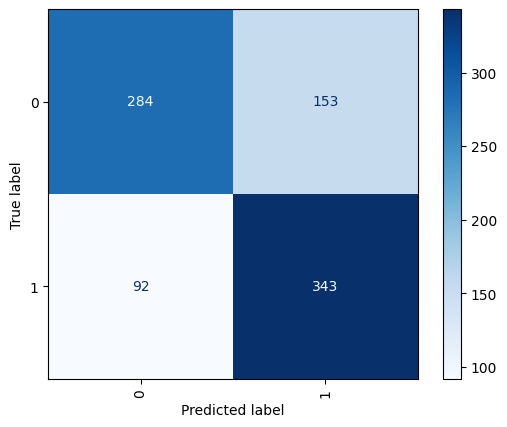

In [ ]:
# Ottiene le etichette reali (ground truth) dal set di dati di test
y_test_tweet = test_tweet["label"].tolist()
# Ottiene le etichette predette dal modello
y_pred_tweet = np.argmax(output_predictions_tweet.predictions, axis=1)

# Calcola il classification report
report_tweet = classification_report(y_test_tweet, y_pred_tweet)
# Crea una rappresentazione grafica della matrice di confusione
cm_tweet = ConfusionMatrixDisplay.from_predictions(y_test_tweet, y_pred_tweet, xticks_rotation='vertical', cmap='Blues')

print("Classification Report su test set:")
print(report_tweet, "\n")

print("Confusion Matrix su test set:")
print(cm_tweet)

####**Modello non specializzato sui tweet**

Classification Report su test set:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       437
           1       0.74      0.77      0.75       435

    accuracy                           0.75       872
   macro avg       0.75      0.75      0.75       872
weighted avg       0.75      0.75      0.75       872
 

Confusion Matrix su test set:


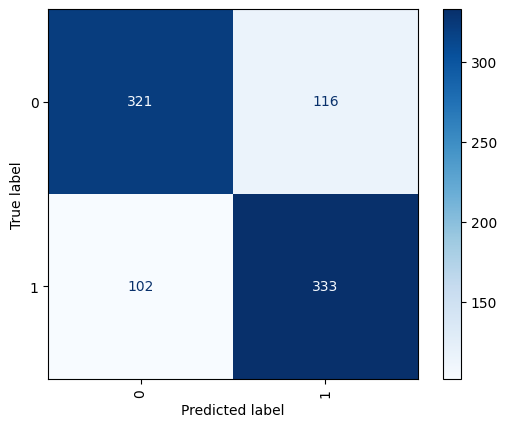

In [ ]:
# Ottiene le etichette reali (ground truth) dal set di dati di test
y_test_basic = test_basic["label"].tolist()
# Ottiene le etichette predette dal modello
y_pred_basic = np.argmax(output_predictions_basic.predictions, axis=1)

# Calcola il classification report
report_basic = classification_report(y_test_basic, y_pred_basic)
# Crea una rappresentazione grafica della matrice di confusione
cm_basic = ConfusionMatrixDisplay.from_predictions(y_test_basic, y_pred_basic, xticks_rotation='vertical', cmap='Blues')

print("Classification Report su test set:")
print(report_basic, "\n")

print("Confusion Matrix su test set:")
print(cm_basic)